### finetuning tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [106]:
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher

feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

In [1]:
from transformers import DeiTFeatureExtractor, DeiTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# note: we are loading a DeiTForImageClassificationWithTeacher from the hub here,
# so the head will be randomly initialized, hence the predictions will be random
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
model = DeiTForImageClassification.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Some weights of the model checkpoint at facebook/deit-tiny-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.weight', 'distillation_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
train_folder_name = "train"
test_folder_name = "test"

data_transforms = {
    train_folder_name: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test_folder_name: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_folder_name, test_folder_name]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in [train_folder_name, test_folder_name]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_folder_name, test_folder_name]}
class_names = image_datasets[train_folder_name].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

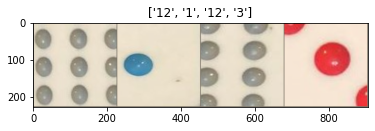

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_folder_name]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # outputs, logits = model(inputs)                    
                    outputs = model(inputs)
                    # print(outputs.logits)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 13)
model = model.to(device)

In [47]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
model = train_model(
    model, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    num_epochs=10,
)

Epoch 0/9
----------
train Loss: 0.1447 Acc: 1.0000
test Loss: 0.3446 Acc: 0.9231

Epoch 1/9
----------
train Loss: 0.1643 Acc: 1.0000
test Loss: 0.3419 Acc: 0.9231

Epoch 2/9
----------
train Loss: 0.2382 Acc: 0.9615
test Loss: 0.3396 Acc: 0.9231

Epoch 3/9
----------
train Loss: 0.1490 Acc: 0.9615
test Loss: 0.3376 Acc: 0.9231

Epoch 4/9
----------
train Loss: 0.3655 Acc: 0.8846
test Loss: 0.3357 Acc: 0.9231

Epoch 5/9
----------
train Loss: 0.1358 Acc: 0.9615
test Loss: 0.3334 Acc: 0.9231

Epoch 6/9
----------
train Loss: 0.1346 Acc: 1.0000
test Loss: 0.3314 Acc: 0.9231

Epoch 7/9
----------
train Loss: 0.1313 Acc: 0.9615
test Loss: 0.3299 Acc: 0.9231

Epoch 8/9
----------
train Loss: 0.2781 Acc: 0.9231
test Loss: 0.3297 Acc: 0.9231

Epoch 9/9
----------
train Loss: 0.1518 Acc: 0.9615
test Loss: 0.3296 Acc: 0.9231

Training complete in 0m 58s
Best test Acc: 0.923077


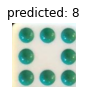

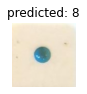

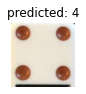

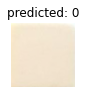

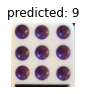

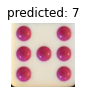

In [55]:
visualize_model(model)